# Basic Project: Transfer Learning

In [1]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

# Torchvision
import torchvision.transforms.functional as F
from torchvision import transforms, datasets, models
from torchvision.transforms import RandAugment

# Visualization
import matplotlib.pyplot as plt
import PIL

# Data Storage / Handling
import os
from tempfile import TemporaryDirectory
import pandas as pd

# Other
import time 
import numpy as np
import random 
import ast


Tic() Toc() Functions to track training time

In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        return time.time() - startTime_for_tictoc
        #print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

Data Root

In [3]:
data_root = "datasets"

Transform for ResNet

In [4]:
# for ResNet:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

Visualize 10 random images

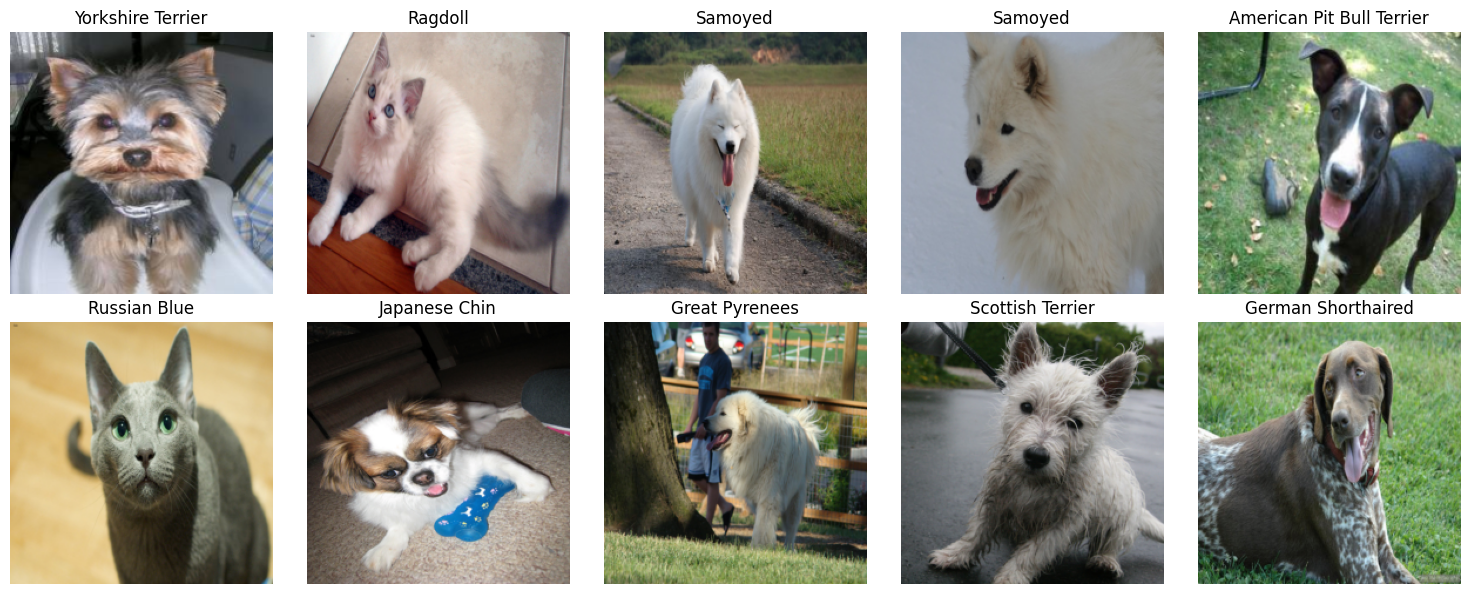

In [5]:

visualize_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='category',
        transform=transform,
        download=False
    )
images2vis, _ = random_split(visualize_dataset, [int(len(visualize_dataset) * 0.8), int(len(visualize_dataset) * 0.2)])

def de_normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(img_tensor, tuple):
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.clone() # avoid modifying the original tensor
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def VisImages(data):
    
    # Randomly select 10 indices
    indices = random.sample(range(len(data)), 10)

    # Extract the corresponding images and labels
    images = [de_normalize(data[i][0]) for i in indices]
    labels = [data.dataset.classes[data[i][1]] for i in indices]

    # Convert tensors to PIL images
    images = [F.to_pil_image(img) for img in images]

    # Display the images and labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for ax, img, label in zip(axes.flatten(), images, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{label}")
    plt.tight_layout()
    plt.show()


# Visualize 
VisImages(images2vis)


Initialize the Device

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("If GPU is available: \npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
    print("Restart the kernel and run the code again.")
    print("Check with `print(torch.cuda.is_available())`")
    print("Documentation: https://pytorch.org/get-started/locally/")

Using device: mps


### Helping Functions:

In [31]:
def set_seed(seed=42):
    import random
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def Load_TrainTestData(data_root, target_types, transform, imbalanced_classes=False, reduction_ratio=0.2):
    generator = torch.Generator().manual_seed(42)
    rng_imbalance = np.random.default_rng(42)

    trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=transform,
        download=False
    )

    val_ratio = 0.2  # 20% for validation
    train_size = int((1 - val_ratio) * len(trainval_data))
    val_size = len(trainval_data) - train_size

    train_data, val_data = random_split(trainval_data, [train_size, val_size], generator=generator)

    if imbalanced_classes:
        # Get target: 0 = cat, 1 = dog
        cat_indices = []
        dog_indices = []

        # label = (breed, species)
        for i, original_idx in enumerate(train_data.indices):
            _, species = trainval_data[original_idx][1]
            if species == 0:  # cat
                cat_indices.append(i)
            else:  # dog
                dog_indices.append(i)


        # Subsample cats to 20%
        reduced_cat_indices = rng_imbalance.choice(cat_indices, int(len(cat_indices) * reduction_ratio), replace=False)

        # Combine reduced cats and all dogs
        final_indices = list(reduced_cat_indices) + dog_indices
        train_data = torch.utils.data.Subset(train_data, final_indices)

    print(f"Total train size after imbalance: {len(train_data)}")

    return train_data, val_data, test_data


def ComputeWeights(dataset, num_classes):
    targets = [dataset[i][1] for i in range(len(dataset))]
    class_counts = np.bincount(targets, minlength=num_classes)
    weights = 1.0 / (class_counts + 1e-5)
    return weights


def DataLoaderFnc(train_data, val_data, test_data, batch_size=32, use_sampler=False, num_classes=None):
    generator = torch.Generator().manual_seed(42)

    # Create DataLoaders
    if use_sampler and num_classes is not None:
        weights = ComputeWeights(train_data, num_classes)
        sampler = torch.utils.data.WeightedRandomSampler(weights, len(train_data), replacement=True)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, generator=generator)
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    dataloaders = {}
    dataset_sizes = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = val_loader
    dataloaders['test'] = test_loader

    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)
    dataset_sizes['test'] = len(test_data)

    # only for data augmentation
    train_indices = train_data.indices

    return dataloaders, dataset_sizes, train_indices


def Initialize_ResNet18(no_target_classes=2):
    network = models.resnet18(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    return network

def Initialize_ResNet34(no_target_classes=2):
    network = models.resnet34(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    return network

def Initialize_ResNet50(no_target_classes=2):
    network = models.resnet50(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    return network



Define transformation to apply for data augmentation and return training set with applied augmentation on the training images. Each time the function is called a different augmentation is returned.

In [32]:
def get_augmented_train_dataset(train_indices, target_types='category'):
    augment_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet
                             std=[0.229, 0.224, 0.225])
    ])
    return Subset(
        datasets.OxfordIIITPet(
            root=data_root,
            split='trainval',
            target_types=target_types,
            transform=augment_transform
        ),
        train_indices
    )

### Function to Train the Network

In [33]:
def train_network(network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25, batch_size=32, data_augmentation = False, train_indices = None, lr_epoch_decr = 0):
    if data_augmentation: print("training with data augmentation")
    eta = optimizer.param_groups[0]['lr'] # get current learning rate, used for lr scheduling

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0

    def evaluate_phase(phase):
        """Helper to evaluate model on a given phase."""
        network.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for X, Y in dataloaders[phase]:
                X = X.to(device)
                # Unpack breed label (Y[0]) and ignore species (Y[1])
                if isinstance(Y, (list, tuple)):
                    Y = Y[0]  # Take breed class only
                Y = Y.to(device)
                S = network(X)
                _, P = torch.max(S, 1)
                loss = criterion(S, Y)

                running_loss += loss.item() * X.size(0)
                running_corrects += torch.sum(P == Y.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.float() / dataset_sizes[phase]
        return epoch_loss, epoch_acc.item()

    # Set Starting Time
    tic()

    with TemporaryDirectory() as tempdir:
        best_network_params_path = os.path.join(tempdir, 'best_network_params.pt')

        torch.save(network.state_dict(), best_network_params_path)
        best_acc = 0.0

        # Step 0: Evaluate before training
        print("Step 0 (Before Training)")
        print('-' * 10)
        for phase in ['train', 'val']:
            loss, acc = evaluate_phase(phase)
            if phase == 'train':
                train_losses.append(loss)
                train_accuracies.append(acc)
            else:
                val_losses.append(loss)
                val_accuracies.append(acc)
            print(f'{phase} Loss: {loss:.4f} Acc: {acc:.4f}')
        print()


        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            if lr_epoch_decr > 0: # decrease learning rate every epoch
                optimizer.param_groups[0]['lr'] = eta * (lr_epoch_decr**epoch) # set learning rate of optimizer, decrease by 1-lr_epoch_decr every epoch

            for phase in ['train', 'val']:
                if phase == 'train':
                    network.train()

                    if data_augmentation:
                        train_dataset = get_augmented_train_dataset(train_indices)
                        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                        dataloaders['train'] = train_loader

                else:
                    network.eval()

                running_loss = 0.0
                running_corrects = 0

                for X, Y in dataloaders[phase]:

                    X = X.to(device)
                    # Unpack breed label (Y[0]) and ignore species (Y[1])
                    if isinstance(Y, (list, tuple)):
                         Y = Y[0]  # Take breed class only
                    Y = Y.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        S = network(X)
                        _, P = torch.max(S, 1)
                        loss = criterion(S, Y)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * X.size(0)
                    running_corrects += torch.sum(P == Y.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                if phase == 'val':
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    torch.save(network.state_dict(), best_network_params_path)
                    print("Better val accuracy. Best model updated.")

            print()

        print(f'Best val Acc: {best_acc:4f}')
        best_val_acc = best_acc.item()

        network.load_state_dict(torch.load(best_network_params_path, weights_only=True))

    # Print Time for Training only
    el_time_training = toc()
    print(f"\nTime for training: {el_time_training:.1f} sec.")

    # Return Network and Training Statistics
    train_stats = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'elapsed_time': el_time_training,
        'best_val_acc': best_val_acc,
    }

    return network, train_stats

In [34]:
def compute_accuracy(network, loader, print_result=True):
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, Y in loader:
            # Unpack breed label (Y[0]) and ignore species (Y[1])
            if isinstance(Y, (list, tuple)):
                Y = Y[0]  # Take breed class only
            X, Y = X.to(device), Y.to(device)
            S = network(X)
            _, P = torch.max(S, 1)
            correct += (P == Y).sum().item()
            total += Y.size(0)

    acc = 100 * correct / total
    if print_result:
        print(f"Test Accuracy: {acc:.2f}%")

    return acc


Function to Plot Loss and Accuracy

In [35]:
def VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs=5):

    plt.figure(facecolor='white', figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0, num_epochs)
    # plt.title('Loss over epochs')
    plt.grid()

    #plt.figure(facecolor='white')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim(0, num_epochs)
    #plt.ylim([0.9, 1.02])
    # plt.title('Accuracy over epochs')
    plt.grid()
    plt.show()


## Binary Classification

In [36]:
def Train_Binary(data_root, target_types, transform, TrainParams):
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    data_augmentation = TrainParams.get('data_augmentation', False)
    model_type = TrainParams.get('model_type', 'ResNet50')

    # Initialize ResNet
    set_seed(42)
    if model_type == 'ResNet18':
        init_network = Initialize_ResNet18(no_target_classes)
    elif model_type == 'ResNet34':
        init_network = Initialize_ResNet34(no_target_classes)
    elif model_type == 'ResNet50':
        init_network = Initialize_ResNet50(no_target_classes)

    # Freeze all parameters
    for param in init_network.parameters():
        param.requires_grad = False
    # Unfreeze only the final layer
    for param in init_network.fc.parameters():
        param.requires_grad = True

    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform)

    # Create DataLoaders
    dataloaders, dataset_sizes, train_indices = DataLoaderFnc(train_data, val_data, test_data, batch_size, use_sampler=None, num_classes=no_target_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr=lr)

    network, train_stats = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=num_epochs, data_augmentation=data_augmentation, train_indices=train_indices
    )

    # Visualize the loss and accuracy of the Network
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, dataloaders['test'], print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc

    return network, train_stats


Train the Network

In [37]:
TrainParams = {
    'model_type': 'ResNet50',
    'batch_size': 32,
    'num_epochs': 10,
    'no_target_classes': 2,
    'lr': 1e-4,
    'data_augmentation': False,
}

TrainYN = False
if TrainYN:
    trained_network, train_stats = Train_Binary(data_root, 'binary-category', transform, TrainParams)

## Multi-Class Problem
- Identifying all 37 breeds of Cats & Dogs

Build one big Training Function

### Strategy 1: Fine-tune $l$ layers simultaneously (including imbalanced classes)

In [38]:
def TrainS1(data_root, target_types, transform, TrainParams):
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    lr_epoch_decr = TrainParams.get('lr_decay_factor', 1e-4)
    lam = TrainParams.get('lam', 1e-4)
    L = TrainParams.get('L', 0)  # Number of layers to fine-tune simultaneously
    data_augmentation = TrainParams.get('data_augmentation', False)
    model_type = TrainParams.get('model_type', 'ResNet18')

    imbalanced_classes = TrainParams.get('imbalanced_classes', False)
    use_weighted_loss = TrainParams.get('use_weighted_loss', False)
    use_sampler = TrainParams.get('use_sampler', False)

    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform, imbalanced_classes=imbalanced_classes)

    # Create DataLoaders
    dataloaders, dataset_sizes, train_indices = DataLoaderFnc(train_data, val_data, test_data, batch_size, use_sampler, num_classes=no_target_classes)

    # Initialize ResNet
    set_seed(42)
    if model_type == 'ResNet18':
        init_network = Initialize_ResNet18(no_target_classes)
    elif model_type == 'ResNet34':
        init_network = Initialize_ResNet34(no_target_classes)
    elif model_type == 'ResNet50':
        init_network = Initialize_ResNet50(no_target_classes)



    for l, (name, module) in enumerate(reversed(list(init_network.named_children()))):
        # amount of parameters that require gradient, if = 0 consider the next layer
        trainable = [p for p in init_network.parameters() if p.requires_grad]
        if len(trainable) == 0 and l <= L: # layer has no params to train and was scheduled to be trained
            print(f"layer {l}: {name} has no params to train, training next layer")
            #L += 1 # add next layer
            continue

        # freeze/ unfreeze layers
        if l <= L:
            print(f"train layer {l}: {name}")
            for p in module.parameters(): p.requires_grad = True
        else:
            for p in module.parameters(): p.requires_grad = False


    # Define the loss function and optimizer
    if use_weighted_loss:
        weights = ComputeWeights(train_data, no_target_classes)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr, weight_decay=lam)

    # Train the network
    network, train_stats = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=num_epochs, batch_size=batch_size,  data_augmentation=data_augmentation, train_indices=train_indices, lr_epoch_decr=lr_epoch_decr,
    )

    # Visualize the loss and accuracy of the Network
    #train_losses, val_losses, train_accuracies, val_accuracies = \
    #            train_stats['train_losses'], train_stats['val_losses'], \
    #            train_stats['train_accuracies'], train_stats['val_accuracies']
    #VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, dataloaders['test'], print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc

    return network, train_stats


In [42]:
# Layers to unfreeze / train
layers = [0, 2, 3, 4, 5, 8, 9] #Only trainable

# Training Parameters
TrainParams = {
    'model_type': 'ResNet50',
    'batch_size': 32,
    'num_epochs': 3,
    'no_target_classes': 37,
    'lr': 1e-4,
    'lr_decay_factor': 0.9,
    'lam': 0.01,
    'L_max': 5,  # Unfreeze the last layer
    'strategy': 'fine-tune',  # 'fine-tune' or 'un-freeze'
    'data_augmentation': True,
    'imbalanced_classes': False,
    'use_weighted_loss': False,
    'use_sampler': False,
}

# Loop through the layers and train the network
train_stats_list = []
TrainYN = False
if TrainYN:
    for l in layers:
        print(f"\nTraining with fine-tuning layers up to layer {l}...")
        TrainParams['L'] = l
        _, train_stats_S1 = TrainS1(data_root, ('category', 'binary-category'), transform, TrainParams)
        print(f"Finished training with fine-tuning layers up to layer {l}.")
        train_stats_list.append(train_stats_S1)
        if TrainParams['imbalanced_classes']:
            filename = f'Results/S1/Imbalanced_classes/{TrainParams["model_type"]}_l={l}_train_stats_S1.csv'
        else:
            filename = f'Results/S1/{TrainParams["model_type"]}_l={l}_train_stats_S1.csv'

        train_stats_S1_df = pd.DataFrame(train_stats_S1)
        train_stats_S1_df.to_csv(filename, index=False)

        print("Training statistics saved")

        if TrainParams['L_max'] < l:
            break

    list_filename = f'Results/S1/{TrainParams["model_type"]}_train_stats_list.csv'
    list_train_stats_df = pd.DataFrame(train_stats_list)
    list_train_stats_df.to_csv(list_filename, index=False)


### Strategy 2: Gradual un-freezing

In [43]:
def Train_S2(data_root, target_types, transform, TrainParams):
    
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    data_augmentation = TrainParams.get('data_augmentation', False)
    model_type = TrainParams.get('model_type', 'ResNet18')
    lam = TrainParams.get('lambda', 0)
    lr_strategy = TrainParams.get('lr_strategy', 'const')
    layer_decr_val = TrainParams.get('layer_decr_val', 0.8)
    epoch_decr_val = TrainParams.get('epoch_decr_val', 0.95)
    train_batch_norm = TrainParams.get('train_batch_norm', True)
    L = TrainParams.get('L', 4)

    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform)

    # Create DataLoaders
    dataloaders, dataset_sizes, train_indices = DataLoaderFnc(train_data, val_data, test_data, batch_size)

    # Initialize ResNet
    if model_type == 'ResNet18':
        init_network = Initialize_ResNet18(no_target_classes)
    elif model_type == 'ResNet34':
        init_network = Initialize_ResNet34(no_target_classes)
    elif model_type == 'ResNet50':
        init_network = Initialize_ResNet50(no_target_classes)


    # Freeze/Unfreeze Layers
    network = init_network
    list_train_stats = []
    print("\nStart Training Network (Strategy: gradually unfreeze layers) ...")

    # current layer to be unfreezed, start with the last layer
    trained_layers = 0
    for layer, (name, _) in enumerate(reversed(list(init_network.named_children()))):

        # Freeze / unfreeze the right layers (gradually unfreeze)
        for l, (_, module) in enumerate(reversed(list(init_network.named_children()))):
            for p in module.parameters(): p.requires_grad = False # freeze all layers

            if l == layer: # unfreeze the current layer
                for p in module.parameters(): p.requires_grad = True

            if not train_batch_norm and isinstance(module, torch.nn.BatchNorm2d): # do not train batch layers
                print(f"No batch norm training for layer {layer}: {name}")
                module.eval()  # Prevents running stats update
                module.weight.requires_grad = False
                module.bias.requires_grad = False

        # amount of parameters that require gradient, if = 0 skip the layer
        trainable = [p for p in network.parameters() if p.requires_grad]
        if len(trainable) == 0:
            print(f"Layer {layer}: {name} has no trainable parameters. Skipping...")
            continue

        trained_layers += 1 # does not include skipped layers

        # calculate current learning rate
        if lr_strategy == 'const':
            eta = lr
            lr_epoch_decr = 0 # do not decrease lr after each epoch
        elif lr_strategy == 'layer_decr':
            eta = lr * (layer_decr_val**(trained_layers-1)) # decrease by 20% (default value) per layer
            lr_epoch_decr = 0 # do not decrease lr after each epoch
        elif lr_strategy == 'layer_epoch_decr':
            eta = lr * (layer_decr_val**trained_layers) # decrease by 20% (default value) per layer
            lr_epoch_decr = epoch_decr_val # Decrease lr in train_network after each epoch by 5% (default value)

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(init_network.parameters(), eta, weight_decay=lam)

        # Train the network (only the unfreezed layers)
        print("------------------------------------------")
        print(f"\nTraining with unfreezing layer {layer}: {name}...")
        network, train_stats = train_network(
            network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=num_epochs, batch_size=batch_size, data_augmentation=data_augmentation, train_indices=train_indices, lr_epoch_decr=lr_epoch_decr
        )
        list_train_stats.append(train_stats)


        # Visualize the loss and accuracy of the Network
        #train_losses, val_losses, train_accuracies, val_accuracies = \
        #        train_stats['train_losses'], train_stats['val_losses'], \
        #        train_stats['train_accuracies'], train_stats['val_accuracies']
        #VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

        if layer >= L:
            break

    # Print the Accuracy
    final_acc = compute_accuracy(network, dataloaders['test'], print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc

    return network, train_stats, list_train_stats

In [45]:
# Training Parameters
TrainParams = {
    'model_type': 'ResNet50',
    'batch_size': 32,
    'num_epochs': 3,
    'no_target_classes': 37,
    'lr': 1e-4,
    'data_augmentation': True,
    'lambda': 0.01,
    'lr_strategy': 'layer_decr',
    'layer_decr_val': 0.8,
    'train_batch_norm': True,
    'L': 5,
}

# Train the network with gradually unfreezing layers
TrainYN = False
if TrainYN:
    trained_net_S2, train_stats_S2, list_train_stats = Train_S2(data_root, 'category', transform, TrainParams)

    train_stats_df = pd.DataFrame([train_stats_S2])
    filename = f"Results/{TrainParams["model_type"]}_{TrainParams["num_epochs"]}epochs_{TrainParams["lambda"]}l2_{TrainParams["lr_strategy"]}_{TrainParams["lr"]}lr_trainbatch{TrainParams["train_batch_norm"]}"
    train_stats_df.to_csv(f"{filename}_train_stats.csv", index=False)

    list_train_stats_df = pd.DataFrame(list_train_stats)
    list_train_stats_df.to_csv(f"{filename}_list_train_stats.csv", index=False)

    print("Training statistics saved")


In [ ]:
### ONLY for plotting

# Load the CSV file into a DataFrame
file_path = "Results/ResNet50_3epochs_0.01l2_layer_decr_lr_trainbatchTrue_list_stats.csv"
file_path_S2 = "Results/ResNet50_3epochs_0.01l2_layer_decr_lr_trainbatchTrue_train_stats.csv"
data_raw = pd.read_csv(file_path)
data_S2 = pd.read_csv(file_path_S2)
data = data_raw.copy()
train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []

data['train_losses'] = data['train_losses'].apply(ast.literal_eval)
data['val_losses'] = data['val_losses'].apply(ast.literal_eval)
data['train_accuracies'] = data['train_accuracies'].apply(ast.literal_eval)
data['val_accuracies'] = data['val_accuracies'].apply(ast.literal_eval)

for i in range(data.shape[0]): # no of layers = 7
        for j in range(len(data['train_losses'][0])): # no of data points per trained layer = 26
            train_loss_list.append(data['train_losses'][i][j])
            val_loss_list.append(data['val_losses'][i][j])
            train_acc_list.append(data['train_accuracies'][i][j])
            val_acc_list.append(data['val_accuracies'][i][j])

plt.figure(facecolor='white', figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
x_lines = [6, 12, 18, 24, 30] #[6, 12, 18, 24, 30, 36, 42]
for x_pos in x_lines:
    plt.axvline(x=x_pos, color='gray', linestyle=':', linewidth=1)
tick_positions = [3 + 6 * i for i in range(4)]  # [0, 26, 52, ..., 156]
tick_labels = ["Layer 0", "Layer 2", "Layer 3", "Layer 4"]
plt.xticks(tick_positions, tick_labels, rotation=0)
plt.tick_params(axis='x', length=0)
plt.legend()
plt.ylabel('Loss')
plt.xlim(0, 30)
plt.ylim([-0.2, 3])
plt.title('Loss over trained layer')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
x_lines = [6, 12, 18, 24, 30] #[6, 12, 18, 24, 30, 36, 42]
for x_pos in x_lines:
    plt.axvline(x=x_pos, color='gray', linestyle=':', linewidth=1)
tick_positions = [3 + 6 * i for i in range(4)]   # [0, 26, 52, ..., 156]
tick_labels = ["Layer 0", "Layer 2", "Layer 3", "Layer 4"]
plt.xticks(tick_positions, tick_labels, rotation=0)
plt.tick_params(axis='x', length=0)
plt.legend()
plt.ylabel('Accuracy')
plt.xlim(0, 30)
plt.ylim([0.6, 1.05])
plt.title('Accuracy over trained layer')
plt.show()

# Extend basic project --> B/A
- FixMatch
- https://github.com/google-research/fixmatch/blob/master/pseudo_label.py


### Data Augmentation
- weak augmentation
- strong augmentation

In [ ]:
def get_strong_augmentation(image_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),
        RandAugment(num_ops=2, magnitude=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_weak_augmentation(image_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet normalization
                             std=[0.229, 0.224, 0.225])
    ])


class TransformFixMatch:
    """Applies weak and strong augmentation to the same input image."""
    def __init__(self, image_size=224):
        self.weak = get_weak_augmentation(image_size)
        self.strong = get_strong_augmentation(image_size)

    def __call__(self, x):
        weak_aug = self.weak(x)
        strong_aug = self.strong(x)
        return weak_aug, strong_aug


# Example usage
transform = TransformFixMatch(image_size=224)
image = PIL.Image.open('datasets/oxford-iiit-pet/images/Abyssinian_1.jpg')
weak_aug, strong_aug = transform(image)
# Visualize the augmentations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.asarray(image))
axes[0].set_title('Original Image')
axes[1].imshow(weak_aug.permute(1, 2, 0).numpy())
axes[1].set_title('Weak Augmentation')
axes[2].imshow(strong_aug.permute(1, 2, 0).numpy())
axes[2].set_title('Strong Augmentation')
plt.show()


Test the TransformFixMatch class (Visualize the Augmentation)

In [ ]:
image_size = 224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Define transforms
weak_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
strong_transform = TransformFixMatch(image_size)  # RandAugment included

# Print the transformations
#print("Weak Transformations:", weak_transform)
#print("Strong Transformations:", strong_transform.strong)

# Extract # random pictures from the dataset
no_pictures = 10
ran_indices = random.sample(range(len(images2vis)), no_pictures)

# Extract the images and labels
ran_images = [de_normalize(images2vis[i][0]) for i in ran_indices]
labels = [images2vis.dataset.classes[images2vis[i][1]] for i in ran_indices]
images_raw = [F.to_pil_image(img) for img in ran_images]


# Apply the transformations to the dataset
images_weakaug = [de_normalize(weak_transform(img)) for img in images_raw]
images_weakaug = [F.to_pil_image(img) for img in images_weakaug]
images_strongaug = [de_normalize(strong_transform(img)[1]) if isinstance(strong_transform(img), tuple) \
    else strong_transform(img) for img in images_raw]
images_strongaug = [F.to_pil_image(img) for img in images_strongaug]

# Visualize the weak and strong augmentations
fig, axes = plt.subplots(3, no_pictures+1, figsize=(20, 5))  # 3 rows, 6 columns (1 for labels, 5 for images)

# Add row labels
row_labels = ["Raw Image:", "Weak Aug:", "Strong Aug:"]
for row, label in enumerate(row_labels):
    axes[row, 0].text(0.5, 0.5, label, fontsize=20, ha='center', va='center')
    axes[row, 0].axis('off')

# Add images and headers
for col, (raw, weak, strong, label) in enumerate(zip(images_raw, images_weakaug, images_strongaug, labels), start=1):
    # First row: raw images with headers
    axes[0, col].imshow(raw)
    axes[0, col].set_title(label, fontsize=12)
    axes[0, col].axis('off')

    # Second row: weak augmentations
    axes[1, col].imshow(weak)
    axes[1, col].axis('off')

    # Third row: strong augmentations
    axes[2, col].imshow(strong)
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()


### Perpare the Dataset
- Split labelled / unlabelled dataset

In [ ]:
def split_labeled_unlabeled(dataset, num_labels_per_class, num_classes, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set random seed for reproducibility
    
    # Access the labels
    try:
        targets = np.array(dataset.targets)  # Use targets attribute if available
    except AttributeError:
        targets = np.array([dataset[i][1] for i in range(len(dataset))])  # Fallback to accessing each sample
    
    labeled_indices = []
    unlabeled_indices = []
    
    for class_idx in range(num_classes):
        class_indices = np.where(targets == class_idx)[0]
        if len(class_indices) < num_labels_per_class:
            raise ValueError(f"Class {class_idx} has fewer samples than num_labels_per_class.")
        
        np.random.shuffle(class_indices)
        labeled_indices.extend(class_indices[:num_labels_per_class])
        unlabeled_indices.extend(class_indices[num_labels_per_class:])
    
    return np.array(labeled_indices), np.array(unlabeled_indices)


def load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeld=32, batch_size_unlabeld=64, image_size=224, seed=None):
    # Common normalization values for ImageNet (can fine-tune later)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
        
    # Define transforms
    transform_FixMatch = TransformFixMatch(image_size)
    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize
    ])
        
    
    # Load the full dataset
    full_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    
    test_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=val_test_transform,
        download=False
    )
    
    # Split into labeled and unlabeled data
    labeled_indices, unlabeled_indices = split_labeled_unlabeled(full_dataset, num_labels_per_class, num_classes, seed=seed)
    
    # Create labeled and unlabeled datasets
    labeled_dataset = Subset(full_dataset, labeled_indices)
    unlabeled_dataset = Subset(full_dataset, unlabeled_indices)
    
    # Apply transforms
    labeled_dataset.dataset.transform = transform_FixMatch.weak # Use only weak augmentation for labeled data
    unlabeled_dataset.dataset.transform = transform_FixMatch    # Use both weak and strong augmentations for unlabeled data
    
    # Optional: make a validation split out of labeled set
    val_ratio = 0.2
    val_size = int(val_ratio * len(labeled_dataset))
    train_size = len(labeled_dataset) - val_size
    labeled_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])
    
    # Dictionary to hold DataLoaders
    dataloaders = {
        'labeled': DataLoader(labeled_dataset, batch_size=batch_size_labeld, shuffle=True),
        'unlabeled': DataLoader(unlabeled_dataset, batch_size=batch_size_unlabeld, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size_labeld, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=batch_size_labeld, shuffle=False)
    }
    
    return dataloaders


### Loss Function

In [ ]:
def compute_fixmatch_loss(logits_x, targets_x, logits_u_w, logits_u_s, threshold=0.95, lambda_u=1.0):

    
    # Supervised loss
    criterion = nn.CrossEntropyLoss(reduction='mean')
    loss_x = criterion(logits_x, targets_x)
    
    # Generate pseudo labels from weakly augmented unlabeled data
    pseudo_labels = torch.softmax(logits_u_w, dim=-1)
    max_probs, targets_u = torch.max(pseudo_labels, dim=-1)
    
    # Mask to select high-confidence pseudo-labels
    mask = max_probs.ge(threshold).float()
    
    # Unsupervised loss (only for confident predictions)
    unsupervised_criterion = nn.CrossEntropyLoss(reduction='none')
    loss_u = (unsupervised_criterion(logits_u_s, targets_u) * mask).mean()
    
    # Total loss
    total_loss = loss_x + lambda_u * loss_u
    
    return total_loss, loss_x, loss_u


### Training Loop

In [ ]:
def train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, device, epoch, lambda_u=1.0, threshold=0.95):
    model.train()

    # Track losses
    running_loss = 0.0
    running_supervised_loss = 0.0
    running_unsupervised_loss = 0.0

    unlabeled_iter = iter(unlabeled_loader)

    for batch_idx, (inputs_x_ws, targets_x) in enumerate(labeled_loader):
        try:
            # Correctly unpack the unlabeled data
            unlabeled_batch = next(unlabeled_iter)
            inputs_u, _ = unlabeled_batch  # Unpack images and ignore labels
            inputs_u_w, inputs_u_s = inputs_u  # Unpack weak and strong augmentations
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            unlabeled_batch = next(unlabeled_iter)
            inputs_u, _ = unlabeled_batch
            inputs_u_w, inputs_u_s = inputs_u

        # Move data to device (GPU or CPU)
        inputs_x, _ = inputs_x_ws # Unpack images (weak and strong augmentations) - Size: [batch_size, 3, 224, 224]
        inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
        inputs_u_w, inputs_u_s = inputs_u_w.to(device), inputs_u_s.to(device)

        # Get batch size
        batch_size = inputs_x.size(0)

        # Forward pass
        logits_x = model(inputs_x)
        logits_u_w = model(inputs_u_w)
        logits_u_s = model(inputs_u_s)

        # Compute FixMatch loss
        total_loss, loss_x, loss_u = compute_fixmatch_loss(
            logits_x, targets_x, logits_u_w, logits_u_s,
            threshold=threshold, lambda_u=lambda_u
        )

        # Optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Statistics
        running_loss += total_loss.item()
        running_supervised_loss += loss_x.item()
        running_unsupervised_loss += loss_u.item()

        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx}] "
                  f"Loss: {total_loss.item():.4f} "
                  f"Supervised Loss: {loss_x.item():.4f} "
                  f"Unsupervised Loss: {loss_u.item():.4f}")

    epoch_loss = running_loss / len(labeled_loader)
    epoch_supervised_loss = running_supervised_loss / len(labeled_loader)
    epoch_unsupervised_loss = running_unsupervised_loss / len(labeled_loader)

    return model, epoch_loss, epoch_supervised_loss, epoch_unsupervised_loss


### Evaluation

In [ ]:
def accuracy(output, target, topk=(1,5)):
    """Computes the top-k accuracy"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # Top-k predictions
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def evaluate(model, dataloader, device):
    model.eval()
    
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            if isinstance(inputs, list):
                inputs = inputs[0]
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            # Compute top-k accuracies
            top1, top5 = accuracy(outputs, targets, topk=(1, 5))
            
            top1_correct += top1.item() * inputs.size(0) / 100.0
            top5_correct += top5.item() * inputs.size(0) / 100.0
            total += inputs.size(0)
    
    top1_acc = 100.0 * top1_correct / total
    top5_acc = 100.0 * top5_correct / total

    print(f"Validation Top-1 Accuracy: {top1_acc:.2f}% | Top-5 Accuracy: {top5_acc:.2f}%")
    
    return top1_acc, top5_acc


Function to Visualize images from Dataloaders (for debugging)

In [ ]:
# Visualize a batch of images
def visualize_dataloader(dataloader, num_images=8):
    # Get a batch of data
    images, labels = next(iter(dataloader))
    
    # Extract images and labels
    print(f"Type of images: {type(images)}")
    print(f"Type of labels: {type(labels)}")
    if isinstance(images, list):
        images = images[0]  # Use only the weakly augmented images
    
    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = de_normalize(images[i])
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")
    plt.show()


### Full Training Script
- Possibility to "speed-up": If more training is necessary:
    - Since the best model is saved at every epoch (if it is better then the previous of course)
    - then it can be loaded again (instead of initialization)
    - and training can be proceeded

    **--> be careful with number of labeled labels though!**

    **FixMatch strongly depends on the labeled images used! (Is also stated in the Google Paper)**
    **This effect, is even more present, if less labeled samples are used.**
        - I would suggest to define the learning strategies from all the studies above (basic assignment) and then apply it to the FixMatch algorithm
        - Run the code a few times (would be good to define lets say 3 or 5 seeds) and report the average test accuracy and std
        - Try e.g. 1, 4, 16, 40 labeled images per class --> a minimum number of labeled samples is therefore obtained

In [ ]:
# Visualize Trend of Top-1 and Top-5 Accuracy
def visualize_accuracy_trend(top1_list, top5_list):
    plt.figure(figsize=(12, 6))
    plt.plot(top1_list, label='Top-1 Accuracy', marker='o')
    plt.plot(top5_list, label='Top-5 Accuracy', marker='o')
    plt.title('Top-1 and Top-5 Accuracy Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()
    plt.show()
    
# Visualize Loss Trend
def visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list):
    plt.figure(figsize=(12, 6))
    plt.plot(loss_list, label='Total Loss', marker='o')
    plt.plot(supervised_loss_list, label='Supervised Loss', marker='o')
    plt.plot(unsupervised_loss_list, label='Unsupervised Loss', marker='o')
    plt.title('Loss Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()



def FixMatch_Train(model_type, num_labels_per_class, num_epochs, seed):

    # Configuration
    data_root = "datasets"
    target_types = 'category'
    num_classes = 37  # Pet dataset (all breeds)
    #num_labels_per_class = 16  # Number of labeled samples per class
        # = 4: Tobi: 79min 25sec training time
        # = 40: Tobi: 1120min training time

    image_size = 224
    batch_size_labeled = 32
    batch_size_unlabeled = batch_size_labeled*5 # 5x more than labeled, typical for FixMatch
    #num_epochs = 30
    threshold = 0.95
    lambda_u = 1.0  # weight for unlabeled loss
    #device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device.type == 'cpu'

    # Initialize ResNet
    if model_type == 'ResNet18':
        model = Initialize_ResNet18(num_classes)
    elif model_type == 'ResNet34':
        model = Initialize_ResNet34(num_classes)
    elif model_type == 'ResNet50':
        model = Initialize_ResNet50(num_classes)
    else:
        print("Implement something `here` to load best model from previous training run.")


    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

    # Data Loaders - here is the randomness!
    dataloaders = load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeled, batch_size_unlabeled, image_size, seed)
    labeled_loader = dataloaders['labeled']
    unlabeled_loader = dataloaders['unlabeled']
    validation_loader = dataloaders['val']
    test_loader = dataloaders['test']

    # Visualize images from the Dataloaders
    debugYN = False
    if debugYN:
        print("\n--- Labeled Data ---")
        visualize_dataloader(dataloaders['labeled'], 10)
        print("\n--- Unlabeled Data ---")
        visualize_dataloader(dataloaders['unlabeled'], 10)
        print("\n--- Validation Data ---")
        visualize_dataloader(dataloaders['val'], 10)
        print("\n--- Test Data ---")
        visualize_dataloader(dataloaders['test'], 10)

    top1_list = []
    top5_list = []
    loss_list = []
    supervised_loss_list = []
    unsupervised_loss_list = []

    # Training Loop
    best_top1 = 0.0
    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")

        # Train
        model, train_loss, train_supervised_loss, train_unsupervised_loss = train_fixmatch(
            model, labeled_loader, unlabeled_loader, optimizer, device, epoch,
            lambda_u=lambda_u, threshold=threshold
        )

        print(f"Train Loss: {train_loss:.4f} | Supervised: {train_supervised_loss:.4f} | Unsupervised: {train_unsupervised_loss:.4f}")
        loss_list.append(train_loss)
        supervised_loss_list.append(train_supervised_loss)
        unsupervised_loss_list.append(train_unsupervised_loss)

        # Evaluate
        val_top1, val_top5 = evaluate(model, validation_loader, device)
        top1_list.append(val_top1)
        top5_list.append(val_top5)

        # Save best model
        if val_top1 > best_top1:
            best_model = model
            best_top1 = val_top1
            torch.save(model.state_dict(), f"best_fixmatch_{model_type}_model_{num_labels_per_class}labels_{seed}seed.pth")
            print("Saved new best model!")
        else:
            print("No improvement, not saving model.")        
            
    return best_model, loss_list, supervised_loss_list, unsupervised_loss_list, top1_list, top5_list



In [ ]:
# Run the FixMatch training
TrainYN = False
if TrainYN:
    model_type = 'ResNet50'  # Choose between 'ResNet18', 'ResNet34', or 'ResNet50'
    seed_list = [2, 3]
    num_labels_per_class = [32, 64]  # Number of labeled samples per class
    num_epochs = 20
    for num_labels in num_labels_per_class:
        print(f"\n------------------------------------------------------------")
        print(f"--- Training with {num_labels} labeled samples per class ---")
        test_top1_list = []
        test_top5_list = []
        for seed in seed_list:
            print(f"\n-------------------")
            print(f"--- Seed {seed} ---")
            model, loss_list, supervised_loss_list, unsupervised_loss_list, top1_list, top5_list = FixMatch_Train(model_type, num_labels, num_epochs, seed)
            
            # Visualize Accuracy and Loss Trends
            visualize_accuracy_trend(top1_list, top5_list)
            visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list)
                
            # Get Test Accuracy with best model
            #model.load_state_dict(torch.load(f"best_fixmatch_{model_type}_model_{num_labels}labels_{seed}seed.pth", weights_only=True))
            test_top1, test_top5 = evaluate(model, dataloaders['test'], device)
            print(f"\nTest Top-1 Accuracy: {test_top1:.2f}% | Test Top-5 Accuracy: {test_top5:.2f}%")
            
            test_top1_list.append(test_top1)
            test_top5_list.append(test_top5)
            

            # Save the loss, top-1 and top-5 list to csv file
            filename = f'fixmatch_training_stats_{model_type}model_{num_labels}labels_{seed}seed.csv'
            df = pd.DataFrame({
                'Epoch': range(1, num_epochs + 1),
                'Top-1 Accuracy': top1_list,
                'Top-5 Accuracy': top5_list,
                'Total Loss': loss_list,
                'Supervised Loss': supervised_loss_list,
                'Unsupervised Loss': unsupervised_loss_list,
                'Test Top-1 Accuracy': test_top1,
                'Test Top-5 Accuracy': test_top5,
            })
            
            # Check if the file already exists
            if os.path.exists(filename):
                # Append to the existing file
                df.to_csv(filename, mode='a', header=False, index=False)
            else:
                # Create a new file
                df.to_csv(filename, index=False)
                
                
        # Print final Test Accuracy with Standard Deviation
        mean_top1 = np.mean(test_top1_list)
        std_top1 = np.std(test_top1_list)
        mean_top5 = np.mean(test_top5_list)
        std_top5 = np.std(test_top5_list)
        print(f"\nFinal Test Top-1 Accuracy: {mean_top1:.2f}% ± {std_top1:.2f}%")
        print(f"Final Test Top-5 Accuracy: {mean_top5:.2f}% ± {std_top5:.2f}%")
    
    

##### Training FixMatch using `unfreeze layers` strategy

In [ ]:
def FixMatch_Train_Unfreezing(model_type, num_labels_per_class, num_epochs, seed):

    # Configuration
    data_root = "datasets"
    target_types = 'category'
    num_classes = 37  # Pet dataset (all breeds)
    image_size = 224
    batch_size_labeled = 32
    batch_size_unlabeled = batch_size_labeled*5 # 5x more than labeled, typical for FixMatch
    threshold = 0.95
    lambda_u = 1.0  # weight for unlabeled loss
    torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device.type == 'cpu'

    # Initialize ResNet
    if model_type == 'ResNet18':
        model = Initialize_ResNet18(num_classes)
    elif model_type == 'ResNet34':
        model = Initialize_ResNet34(num_classes)
    elif model_type == 'ResNet50':
        model = Initialize_ResNet50(num_classes)
    else:
        print("Implement something `here` to load best model from previous training run.")


    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

    # Data Loaders - here is the randomness!
    dataloaders = load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeled, batch_size_unlabeled, image_size, seed)
    labeled_loader = dataloaders['labeled']
    unlabeled_loader = dataloaders['unlabeled']
    validation_loader = dataloaders['val']
    test_loader = dataloaders['test']

    top1_list, top5_list = [], []
    test_top1_list, test_top5_list = [], []    
    loss_list, supervised_loss_list, unsupervised_loss_list = [], [], []    
    
    best_top1 = 0.0

    # Freeze/Unfreeze Layers
    for layer, (name, _) in enumerate(reversed(list(model.named_children()))):
        # Freeze / unfreeze the right layers (gradually unfreeze)
        for l, (_, module) in enumerate(reversed(list(model.named_children()))):
            for p in module.parameters(): p.requires_grad = False # freeze all layers
            if l == layer: # unfreeze the current layer
                for p in module.parameters(): p.requires_grad = True
                
        # amount of parameters that require gradient, if = 0 skip the layer
        trainable = [p for p in model.parameters() if p.requires_grad]
        if len(trainable) == 0:
            print(f"Layer {layer}: {name} has no trainable parameters. Skipping...")
            continue
        
        # Train the network (only the unfreezed layers)
        print("\n------------------------------------------")
        print(f"\nTraining with unfreezing layer {layer}: {name}...")
        
        for epoch in range(1, num_epochs + 1):
            print(f"\n--- Epoch {epoch}/{num_epochs} ---")
            model, train_loss, train_supervised_loss, train_unsupervised_loss = train_fixmatch(
                model, labeled_loader, unlabeled_loader, optimizer, device, epoch,
                lambda_u=lambda_u, threshold=threshold
            )

            print(f"Train Loss: {train_loss:.4f} | Supervised: {train_supervised_loss:.4f} | Unsupervised: {train_unsupervised_loss:.4f}")
            loss_list.append(train_loss)
            supervised_loss_list.append(train_supervised_loss)
            unsupervised_loss_list.append(train_unsupervised_loss)
            
            # Evaluate
            val_top1, val_top5 = evaluate(model, validation_loader, device)
            test_top1, test_top5 = evaluate(model, test_loader, device)
            top1_list.append(val_top1)
            top5_list.append(val_top5)
            test_top1_list.append(test_top1)
            test_top5_list.append(test_top5)
            
            # Save best model
            if val_top1 > best_top1:
                best_model = model
                best_top1 = val_top1
                torch.save(model.state_dict(), f"best_fixmatch_unfreezing_{model_type}_model_{num_labels_per_class}labels_{seed}seed.pth")
                print("Saved new best model!")
            else:
                print("No improvement, not saving model.")

        if layer >= 4:
            break
            
            
    return best_model, loss_list, supervised_loss_list, unsupervised_loss_list, top1_list, top5_list


In [ ]:
    # Data Loaders - here is the randomness!
dataloaders = []

In [ ]:
# Train the network with gradually unfreezing layers
TrainYN = True
if TrainYN:
    #device.type == 'cpu'
    model_type = 'ResNet50'  # Choose between 'ResNet18', 'ResNet34', or 'ResNet50'
    seed_list = [1, 2, 3]
    num_labels_per_class = [100, 40, 20, 1]  # Number of labeled samples per class
    num_epochs = 3
    for num_labels in num_labels_per_class:
        print(f"\n------------------------------------------------------------")
        print(f"--- Training with {num_labels} labeled samples per class ---")
        test_top1_list = []
        test_top5_list = []
        for seed in seed_list:
            print(f"\n-------------------")
            print(f"--- Seed {seed} ---")
            best_model, loss_list, supervised_loss_list, unsupervised_loss_list, \
                top1_list, top5_list = FixMatch_Train_Unfreezing(
                model_type, num_labels, num_epochs, seed
            )
            
            # Visualize Accuracy and Loss Trends
            visualize_accuracy_trend(top1_list, top5_list)
            visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list)
                
            # Get Test Accuracy with best model
            model.load_state_dict(torch.load(f"best_fixmatch_unfreezing_{model_type}_model_{num_labels}labels_{seed}seed.pth", weights_only=True))
            test_top1, test_top5 = evaluate(model, dataloaders['test'], device)
            print(f"\nTest Top-1 Accuracy: {test_top1:.2f}% | Test Top-5 Accuracy: {test_top5:.2f}%")
            
            test_top1_list.append(test_top1)
            test_top5_list.append(test_top5)
            

            # Save the loss, top-1 and top-5 list to csv file
            filename = f'fixmatch_unfreezing_training_stats_{model_type}model_{num_labels}labels_{seed}seed.csv'
            df = pd.DataFrame({
                'Epoch': range(1, num_epochs + 1),
                'Top-1 Accuracy': top1_list,
                'Top-5 Accuracy': top5_list,
                'Total Loss': loss_list,
                'Supervised Loss': supervised_loss_list,
                'Unsupervised Loss': unsupervised_loss_list,
                'Test Top-1 Accuracy': test_top1,
                'Test Top-5 Accuracy': test_top5,
            })
            
            # Check if the file already exists
            if os.path.exists(filename):
                # Append to the existing file
                df.to_csv(filename, mode='a', header=False, index=False)
            else:
                # Create a new file
                df.to_csv(filename, index=False)
                
                
        # Print final Test Accuracy with Standard Deviation
        mean_top1 = np.mean(test_top1_list)
        std_top1 = np.std(test_top1_list)
        mean_top5 = np.mean(test_top5_list)
        std_top5 = np.std(test_top5_list)
        print(f"\nFinal Test Top-1 Accuracy: {mean_top1:.2f}% ± {std_top1:.2f}%")
        print(f"Final Test Top-5 Accuracy: {mean_top5:.2f}% ± {std_top5:.2f}%")



##### Training FixMatch using `simultaneous training` strategy


In [ ]:
def FixMatch_Train_simultaneous(model_type, labels2learn, num_labels_per_class, num_epochs, seed):

    # Configuration
    data_root = "datasets"
    target_types = 'category'
    num_classes = 37  # Pet dataset (all breeds)
    image_size = 224
    batch_size_labeled = 32
    batch_size_unlabeled = batch_size_labeled*5 # 5x more than labeled, typical for FixMatch
    threshold = 0.95
    lambda_u = 1.0  # weight for unlabeled loss
    #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device.type == 'cpu'

    # Initialize ResNet
    if model_type == 'ResNet18':
        model = Initialize_ResNet18(num_classes)
    elif model_type == 'ResNet34':
        model = Initialize_ResNet34(num_classes)
    elif model_type == 'ResNet50':
        model = Initialize_ResNet50(num_classes)
    else:
        print("Implement something `here` to load best model from previous training run.")


    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

    # Data Loaders - here is the randomness!
    dataloaders = load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeled, batch_size_unlabeled, image_size, seed)
    labeled_loader = dataloaders['labeled']
    unlabeled_loader = dataloaders['unlabeled']
    validation_loader = dataloaders['val']
    test_loader = dataloaders['test']

    top1_list, top5_list = [], []
    test_top1_list, test_top5_list = [], []    
    loss_list, supervised_loss_list, unsupervised_loss_list = [], [], []    
    
    best_top1 = 0.0

    # Freeze/Unfreeze Layers
    for layer, (_, module) in enumerate(reversed(list(model.named_children()))):
        for p in module.parameters(): p.requires_grad = False # freeze all layers
        if layer <= labels2learn: # unfreeze layers to learn
            for p in module.parameters(): p.requires_grad = True
            
    # Train the network    
    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")
        model, train_loss, train_supervised_loss, train_unsupervised_loss = train_fixmatch(
            model, labeled_loader, unlabeled_loader, optimizer, device, epoch,
            lambda_u=lambda_u, threshold=threshold
        )

        print(f"Train Loss: {train_loss:.4f} | Supervised: {train_supervised_loss:.4f} | Unsupervised: {train_unsupervised_loss:.4f}")
        loss_list.append(train_loss)
        supervised_loss_list.append(train_supervised_loss)
        unsupervised_loss_list.append(train_unsupervised_loss)
        
        # Evaluate
        val_top1, val_top5 = evaluate(model, validation_loader, device)
        top1_list.append(val_top1)
        top5_list.append(val_top5)
        
        # Save best model
        if val_top1 > best_top1:
            best_model = model
            best_top1 = val_top1
            torch.save(model.state_dict(), f"best_fixmatch_unfreezing_{model_type}_model_{num_labels_per_class}labels_{seed}seed.pth")
            print("Saved new best model!")
        else:
            print("No improvement, not saving model.")        
                
    # Get Test Accuracy with best model
    test_top1, test_top5 = evaluate(best_model, test_loader, device)
    print(f"\nTest Top-1 Accuracy: {test_top1:.2f}% | Test Top-5 Accuracy: {test_top5:.2f}%")
            
    return best_model, loss_list, supervised_loss_list, unsupervised_loss_list, top1_list, top5_list


In [ ]:
# Train the network with training l layer simultaneously
TrainYN = True
if TrainYN:
    model_type = 'ResNet50'  # Choose between 'ResNet18', 'ResNet34', or 'ResNet50'
    seed_list = [1]
    num_labels_per_class = [4, 16, 32, 64]  # Number of labeled samples per class
    layers_simul_list = [3]
    num_epochs = 3
    for labels2learn in layers_simul_list:
        for num_labels in num_labels_per_class:
            print(f"\n------------------------------------------------------------")
            print(f"--- Training with {num_labels} labeled samples per class ---")
            test_top1_list = []
            test_top5_list = []
            for seed in seed_list:
                print(f"\n-------------------")
                print(f"--- Seed {seed} ---")
                best_model, loss_list, supervised_loss_list, unsupervised_loss_list, \
                    top1_list, top5_list = FixMatch_Train_simultaneous(
                        model_type, labels2learn, num_labels, num_epochs, seed)
                
                # Visualize Accuracy and Loss Trends
                visualize_accuracy_trend(top1_list, top5_list)
                visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list)
                    
                # Get Test Accuracy with best model
                model.load_state_dict(torch.load(f"best_fixmatch_unfreezing_{model_type}_model_{num_labels}labels_{seed}seed.pth", weights_only=True))
                test_top1, test_top5 = evaluate(model, dataloaders['test'], device)
                print(f"\nTest Top-1 Accuracy: {test_top1:.2f}% | Test Top-5 Accuracy: {test_top5:.2f}%")
                
                test_top1_list.append(test_top1)
                test_top5_list.append(test_top5)
                

                # Save the loss, top-1 and top-5 list to csv file
                filename = f'fixmatch_unfreezing_training_stats_{model_type}model_{num_labels}labels_{seed}seed.csv'
                df = pd.DataFrame({
                    'Epoch': range(1, num_epochs + 1),
                    'Top-1 Accuracy': top1_list,
                    'Top-5 Accuracy': top5_list,
                    'Total Loss': loss_list,
                    'Supervised Loss': supervised_loss_list,
                    'Unsupervised Loss': unsupervised_loss_list,
                    'Test Top-1 Accuracy': test_top1,
                    'Test Top-5 Accuracy': test_top5,
                })
                
                # Check if the file already exists
                if os.path.exists(filename):
                    # Append to the existing file
                    df.to_csv(filename, mode='a', header=False, index=False)
                else:
                    # Create a new file
                    df.to_csv(filename, index=False)
                    
                    
            # Print final Test Accuracy with Standard Deviation
            mean_top1 = np.mean(test_top1_list)
            std_top1 = np.std(test_top1_list)
            mean_top5 = np.mean(test_top5_list)
            std_top5 = np.std(test_top5_list)
            print(f"\nFinal Test Top-1 Accuracy: {mean_top1:.2f}% ± {std_top1:.2f}%")
            print(f"Final Test Top-5 Accuracy: {mean_top5:.2f}% ± {std_top5:.2f}%")
